Init data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from src.utils.helpers import create_graph_from_data, get_connected_components, get_communities
from src.utils.helpers import merge_movies_and_actors, filter_by_country, drop_nans, fix_date, filter_by_language
from src.data import load_characters, load_movies, load_plots, load_awards, load_nominations

movies = load_movies()
characters = load_characters()
actor_awards = load_awards()  
actor_nominations = load_nominations()  

us_movies = filter_by_country(movies, country="United States of America")
print("Number of US movies:", us_movies.shape[0])

us_movies = drop_nans(us_movies, column="Revenue")
us_movies = drop_nans(us_movies, column="ReleaseDate")
us_movies = fix_date(us_movies, column="ReleaseDate")
print("Number of US movies after dropping Nans:", us_movies.shape[0])
us_movies = filter_by_language(us_movies, language="English Language")

actor_awards['TotalActorAwards'] = actor_awards['awards'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)
actor_nominations['TotalActorNominations'] = actor_nominations['nominations'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

us_characters_movies = merge_movies_and_actors(us_movies, characters)

Number of US movies: 34408
Number of US movies after dropping Nans: 6923


Create graph and Merge actor awards/nominations with character data

In [2]:
G_US = create_graph_from_data(us_characters_movies)
print(f"Number of vertices: {len(G_US.nodes)}, number of edges: {len(G_US.edges)}")

connected_component_sizes = sorted(map(len, get_connected_components(G_US)), reverse=True)
print(f"Number of components: {len(connected_component_sizes)}, sizes of top-5 components: {connected_component_sizes[:5]} ")

communities_US = get_communities(G_US)
community_sizes = sorted(map(len, communities_US), reverse=True)
print(f"Number of communities: {len(communities_US)}, sizes of top-5 communities: {community_sizes[:5]} ")

actor_awards = actor_awards.rename(columns={'freebase_ids': 'FreebaseActorId'})
actor_nominations = actor_nominations.rename(columns={'freebase_ids': 'FreebaseActorId'})
actor_metrics = (
    us_characters_movies[['FreebaseActorId']]
    .drop_duplicates()
    .merge(actor_awards[['FreebaseActorId', 'TotalActorAwards']], how='left', on='FreebaseActorId')
    .merge(actor_nominations[['FreebaseActorId', 'TotalActorNominations']], how='left', on='FreebaseActorId')
)

actor_metrics['TotalActorAwards'] = actor_metrics['TotalActorAwards'].fillna(0).astype(int)
actor_metrics['TotalActorNominations'] = actor_metrics['TotalActorNominations'].fillna(0).astype(int)

Number of vertices: 30379, number of edges: 613672
Number of components: 71, sizes of top-5 components: [30005, 18, 18, 17, 16] 
Number of communities: 139, sizes of top-5 communities: [7162, 5477, 4817, 3859, 665] 


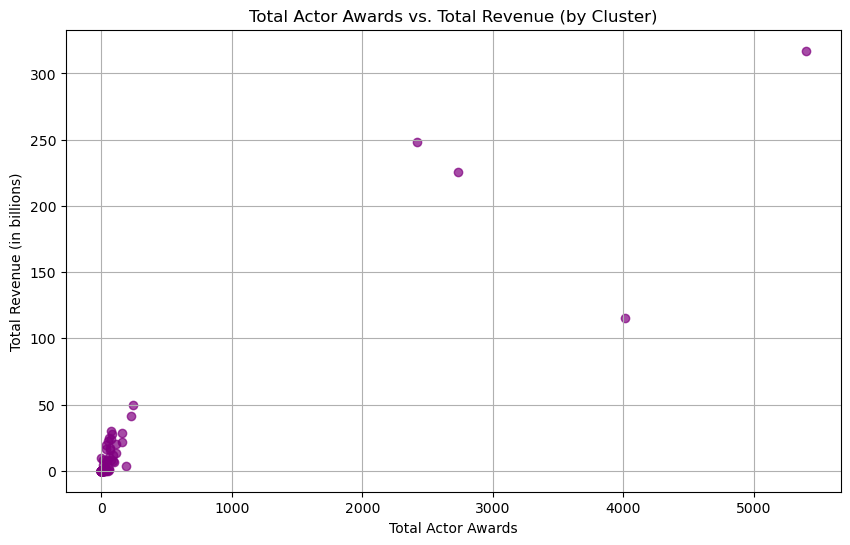

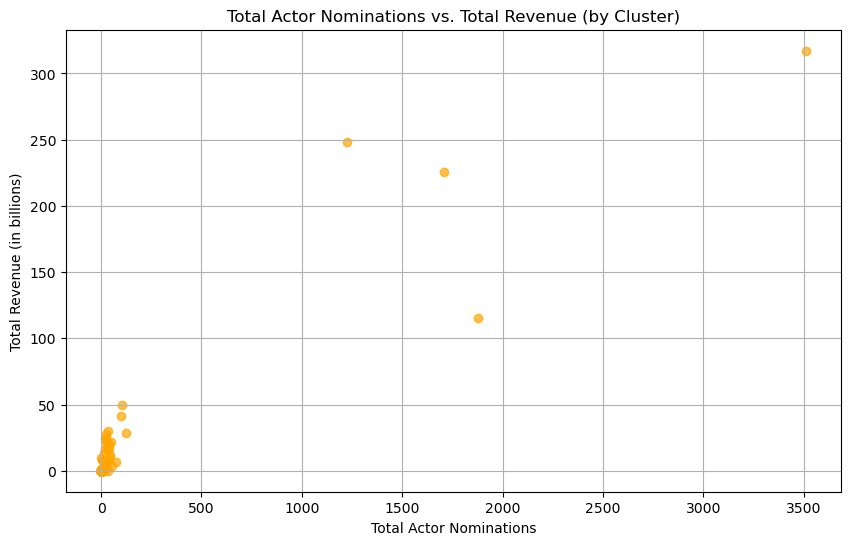

Correlation between total actor awards and total revenue: 0.92
Correlation between total actor nominations and total revenue: 0.93


In [3]:

# Compute metrics for each community based on actor-level data
def compute_cluster_metrics_actors(communities, us_characters_movies, actor_metrics):
    """
    Compute metrics for each community based on actor-level data:
    - Total revenue
    - Total actor awards
    - Total actor nominations
    - Number of actors in the community
    """
    cluster_metrics = {}

    for community_id, community_members in enumerate(communities):
        # Filter the actor for community
        community_actor_metrics = actor_metrics[actor_metrics.FreebaseActorId.isin(community_members)]

        # Calculate total awards/nominations
        total_actor_awards = community_actor_metrics['TotalActorAwards'].sum()
        total_actor_nominations = community_actor_metrics['TotalActorNominations'].sum()

        # Calculate total revenue based on movies
        community_movie_ids = us_characters_movies[us_characters_movies.FreebaseActorId.isin(community_members)].FreebaseId.unique()
        total_revenue = us_movies[us_movies.FreebaseId.isin(community_movie_ids)]['Revenue'].sum()
        total_revenue_in_billions = total_revenue / 1_000_000_000

        cluster_metrics[community_id] = {
            "total_revenue": float(f"{total_revenue_in_billions:.2f}"),
            "total_actor_awards": total_actor_awards,
            "total_actor_nominations": total_actor_nominations,
            "num_actors": len(community_members)
        }

    return cluster_metrics


cluster_metrics_actor_awards = compute_cluster_metrics_actors(communities_US, us_characters_movies, actor_metrics)

total_revenues_actors = [metrics["total_revenue"] for metrics in cluster_metrics_actor_awards.values()]
total_actor_awards = [metrics["total_actor_awards"] for metrics in cluster_metrics_actor_awards.values()]
total_actor_nominations = [metrics["total_actor_nominations"] for metrics in cluster_metrics_actor_awards.values()]

plt.figure(figsize=(10, 6))
plt.scatter(total_actor_awards, total_revenues_actors, alpha=0.7, color="purple")
plt.title("Total Actor Awards vs. Total Revenue (by Cluster)")
plt.xlabel("Total Actor Awards")
plt.ylabel("Total Revenue (in billions)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(total_actor_nominations, total_revenues_actors, alpha=0.7, color="orange")
plt.title("Total Actor Nominations vs. Total Revenue (by Cluster)")
plt.xlabel("Total Actor Nominations")
plt.ylabel("Total Revenue (in billions)")
plt.grid(True)
plt.show()


correlation_actor_awards = np.corrcoef(total_actor_awards, total_revenues_actors)[0, 1]
print(f"Correlation between total actor awards and total revenue: {correlation_actor_awards:.2f}")

correlation_actor_nominations = np.corrcoef(total_actor_nominations, total_revenues_actors)[0, 1]
print(f"Correlation between total actor nominations and total revenue: {correlation_actor_nominations:.2f}")
